**Кирилл Конча Д/З 7**

In [126]:
import pandas as pd

df = pd.read_csv("/content/winemag-data-130k-v2.csv", index_col="Unnamed: 0")

In [12]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [132]:
df = df.drop_duplicates()

**Кластеризация 1:** K-means для кластеризации сортов вина по описанию

Как видно, сортов очень много. Можно посчитать число строк с разными сортами и взять самые популярные

In [17]:
len(df["variety"].unique())

708

In [21]:
from collections import Counter

cnt = Counter(df["variety"].to_list())

In [23]:
cnt.most_common(20)

[('Pinot Noir', 12278),
 ('Chardonnay', 10868),
 ('Cabernet Sauvignon', 8840),
 ('Red Blend', 8243),
 ('Bordeaux-style Red Blend', 6471),
 ('Riesling', 4773),
 ('Sauvignon Blanc', 4575),
 ('Syrah', 3828),
 ('Rosé', 3220),
 ('Merlot', 2896),
 ('Nebbiolo', 2607),
 ('Zinfandel', 2530),
 ('Sangiovese', 2462),
 ('Malbec', 2446),
 ('Portuguese Red', 2282),
 ('White Blend', 2179),
 ('Sparkling Blend', 1971),
 ('Tempranillo', 1671),
 ('Rhône-style Red Blend', 1343),
 ('Pinot Gris', 1324)]

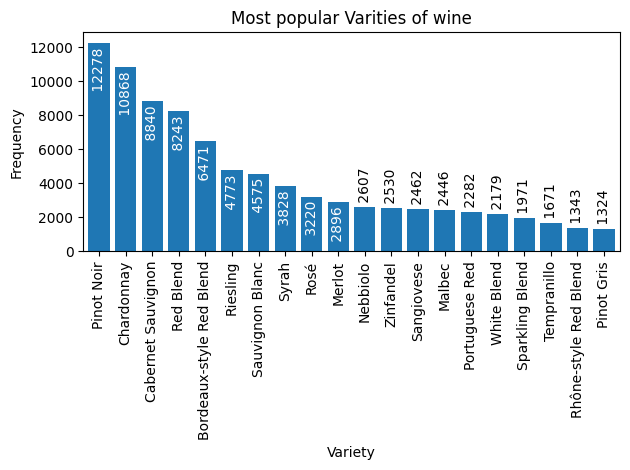

In [27]:
import numpy as np
from matplotlib import pyplot as plt

x = [tag for tag, count in cnt.most_common(20)]
y = [count for tag, count in cnt.most_common(20)]


plt.bar(x, y)
plt.title("Most popular Varities of wine")
plt.ylabel("Frequency")
plt.xlabel("Variety")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(cnt.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

Теперь оставлю только те строки, у которых Variety входит в топ-20 по частотности

In [130]:
df = df[~df['variety'].isin(x)]

In [133]:
len(df)

33181

Токенизирую и лемматизирую описания, чтобы получить матрицу TF-IDF

In [167]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

  
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text.lower())]

In [58]:
vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'), tokenizer = tokenize, max_features = 1000)
X = vectorizer.fit_transform(df["description"].to_list())
words = vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


In [79]:
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
  
    distortions.append(sum(np.min(cdist(X.toarray(), kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X.toarray(), kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Согласно K-плечу, самое оптимальное число кластеров -- 5.

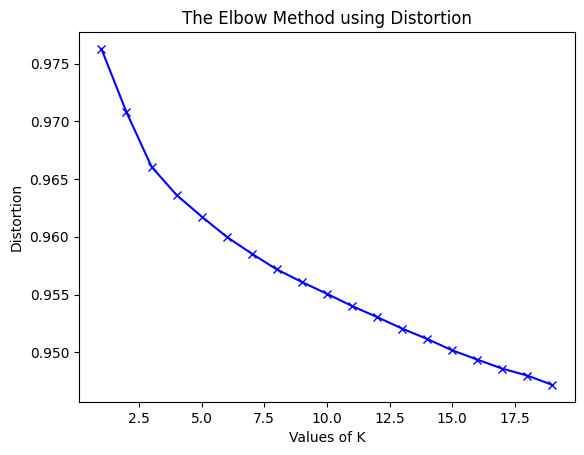

In [83]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [90]:
kmeanModel = KMeans(n_clusters=5).fit(X)

In [135]:
df['cluster'] = kmeanModel.labels_

Посмотрим, какие слова характеризуют каждый кластер

In [92]:
common_words = kmeanModel.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : wine, crisp, fruity, drink, acidity, ready, light, ha, fresh, attractive
1 : wine, fruit, rich, ripe, ha, drink, acidity, wood, aging, character
2 : flavor, wine, finish, aroma, peach, palate, white, fruit, citrus, fresh
3 : cherry, black, flavor, aroma, tannin, berry, finish, plum, fruit, red
4 : white, palate, apple, flower, offer, acidity, aroma, yellow, peach, alongside


Посмотрим самый популярный сорт вина для каждого кластера

In [121]:
df.groupby(['cluster'])['variety'].agg(pd.Series.mode)

cluster
0    Portuguese White
1               Gamay
2            Viognier
3      Cabernet Franc
4               Glera
Name: variety, dtype: object

Посмотрим 5 самых частотных вин для каждого кластера. Если бы я разбирался во вкусах вин, то мог бы сказать, что кластеризуются похожие по вкусу. А так могу сказать, что кластеры достаточно разные.

In [136]:
top_wine = (df.assign(count=df.groupby(["cluster","variety"])["variety"].transform("count"))
        .drop_duplicates(["cluster","variety"])
        .sort_values(["cluster","count"], ascending=False))

In [125]:
print(pd.DataFrame([i["variety"].unique()[:5] for _, i in top_wine.groupby("cluster")]).fillna(np.NaN))

                  0                 1                           2  \
0  Portuguese White   Champagne Blend  Bordeaux-style White Blend   
1             Gamay   Champagne Blend                        Port   
2          Viognier  Grüner Veltliner                Pinot Grigio   
3    Cabernet Franc            Shiraz           Sangiovese Grosso   
4             Glera      Pinot Grigio                   Garganega   

                            3                 4  
0                       Gamay  Grüner Veltliner  
1  Bordeaux-style White Blend  Portuguese White  
2              Gewürztraminer          Albariño  
3                Petite Sirah           Barbera  
4                   Sauvignon          Turbiana  


Теперь посчитаем silhoutte score для 5 кластеров

In [141]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm


def calculate_silhouette(labels, X):
  """
  Takes data and clusters preducted by model

  Returns plot with silhouette coefficient
  """
  cluster_labels = np.unique(labels)
  n_clusters = cluster_labels.shape[0]
  silhouette_vals = silhouette_samples(X, labels, metric='euclidean')
  y_ax_lower, y_ax_upper = 0, 0
  yticks = []
  for i, c in enumerate(cluster_labels):
      c_silhouette_vals = silhouette_vals[labels == c]
      c_silhouette_vals.sort()
      y_ax_upper += len(c_silhouette_vals)
      color = cm.jet(float(i) / n_clusters)
      plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
              edgecolor='none', color=color)

      yticks.append((y_ax_lower + y_ax_upper) / 2.)
      y_ax_lower += len(c_silhouette_vals)
    
  silhouette_avg = np.mean(silhouette_vals)
  plt.axvline(silhouette_avg, color="red", linestyle="--") 

  plt.yticks(yticks, cluster_labels + 1)
  plt.ylabel('Cluster')
  plt.xlabel('Silhouette coefficient')

  plt.tight_layout()
  plt.show()

В целом, silhoutte score неплохой

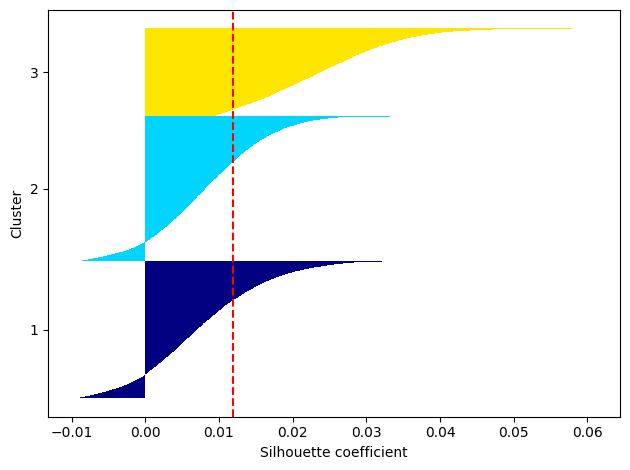

In [142]:
calculate_silhouette(kmeanModel.labels_, X)

Теперь обучим модель на 20 кластерах

In [143]:
kmeanModel = KMeans(n_clusters=20).fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [144]:
df['cluster'] = kmeanModel.labels_

В целом, кластеризация получилась неплохая. Правда, в итоге не все уникальные лейблы указались доминирующими в каком-то из кластеров. Впрочем, это может быть по той причине, что некоторые сорта по вкусу и описанию бывают очень похожими друг на друга.

In [145]:
df.groupby(['cluster'])['variety'].agg(pd.Series.mode)

cluster
0                Petite Sirah
1            Grüner Veltliner
2                   Carmenère
3                     Barbera
4                Pinot Grigio
5                    Albariño
6                       Glera
7              Cabernet Franc
8              Cabernet Franc
9                      Shiraz
10               Pinot Grigio
11            Champagne Blend
12                   Viognier
13                      Gamay
14           Portuguese White
15          Sangiovese Grosso
16           Portuguese White
17             Cabernet Franc
18    Rhône-style White Blend
19            Champagne Blend
Name: variety, dtype: object

Silhoutte score выглядит не очень хорошо...

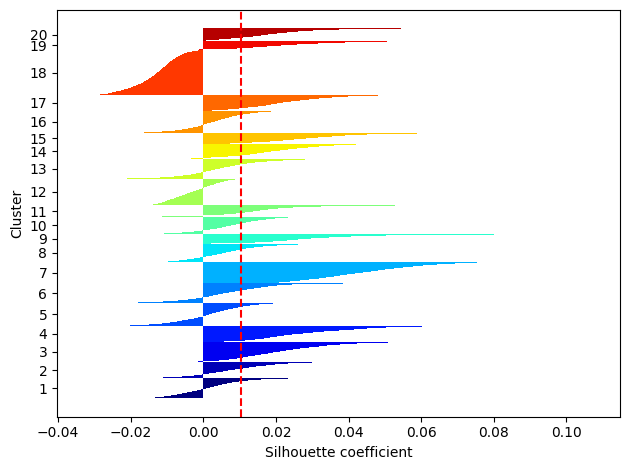

In [146]:
calculate_silhouette(kmeanModel.labels_, X)

**Кластеризация 2:** Description и Points в зависимости от цены. Посмотрим, сможет ли DBSCAN разделить вина на дешевые и дорогие

In [184]:
df = pd.read_csv("/content/winemag-data-130k-v2.csv", index_col="Unnamed: 0")

df = df[["points", "description", "price", "variety"]]
df = df.dropna()

In [150]:
df.price.min()

4.0

In [151]:
df.price.max()

1100.0

Посмотрим на ценовый диапазон вин. Как можно видеть, очень дорогих (>1000) вин очень мало. Объединим их с диапазоном 100-1000 и пометим в датафрейме

In [160]:
print("Number of wines that are less expensive that 100:",len(df[df['price']<=100]))
print("Number of wines priced in range of 100-1000:",len(df[(df['price']>100) & (df['price']<=1000)]))
print("Number of wines priced in range of >1000:",len(df[df['price']>1000]))

Number of wines that are less expensive that 100: 117609
Number of wines priced in range of 100-1000: 3352
Number of wines priced in range of >1000: 14


In [185]:
df['cheapesness'] = np.where(df['price'] > 100, 'expensive', 'cheap')

<ipython-input-185-27a13d89e37b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cheapesness'] = np.where(df['price'] > 100, 'expensive', 'cheap')


In [170]:
df.head()

,points,description,price,cheapesness
1,87,"This is ripe and fruity, a wine that is smooth...",15.0,cheap
2,87,"Tart and snappy, the flavors of lime flesh and...",14.0,cheap
3,87,"Pineapple rind, lemon pith and orange blossom ...",13.0,cheap
4,87,"Much like the regular bottling from 2012, this...",65.0,cheap
5,87,Blackberry and raspberry aromas show a typical...,15.0,cheap


Интересно посмотреть на облаки слов для дорогих и дешевых вин

Дешевые:

(-0.5, 999.5, 799.5, -0.5)

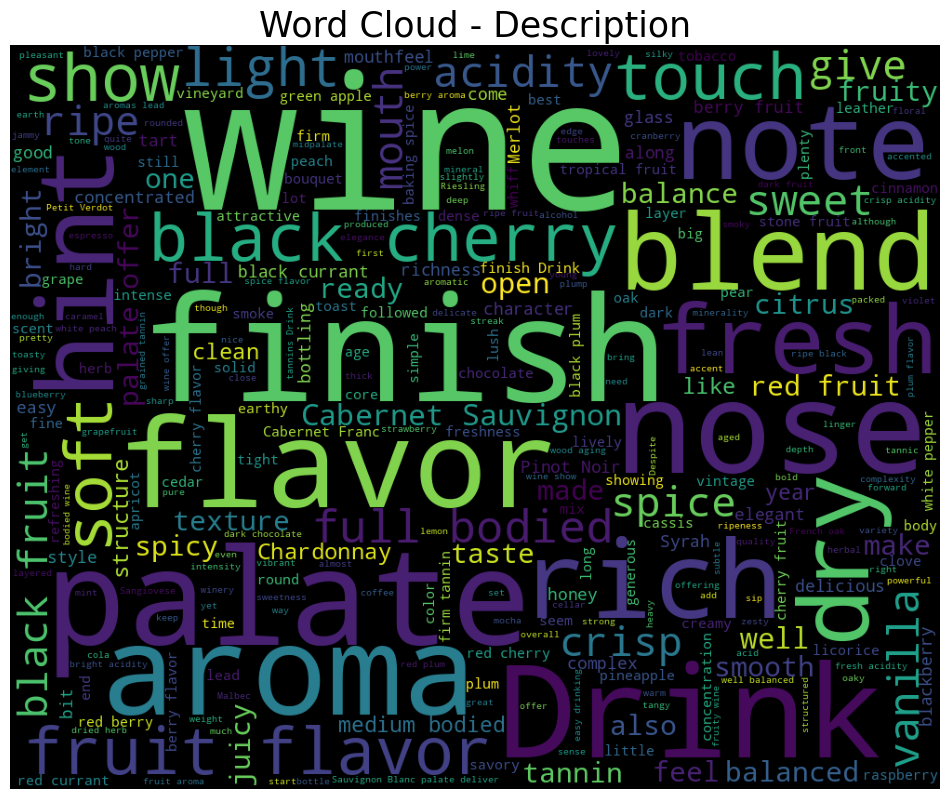

In [171]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator


wordcloud = WordCloud(
    stopwords=stopwords.words('english'),
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df[df["price"]<=100]["description"].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("Word Cloud - Description",fontsize=25)
plt.axis('off')

Дорогие:

(-0.5, 999.5, 799.5, -0.5)

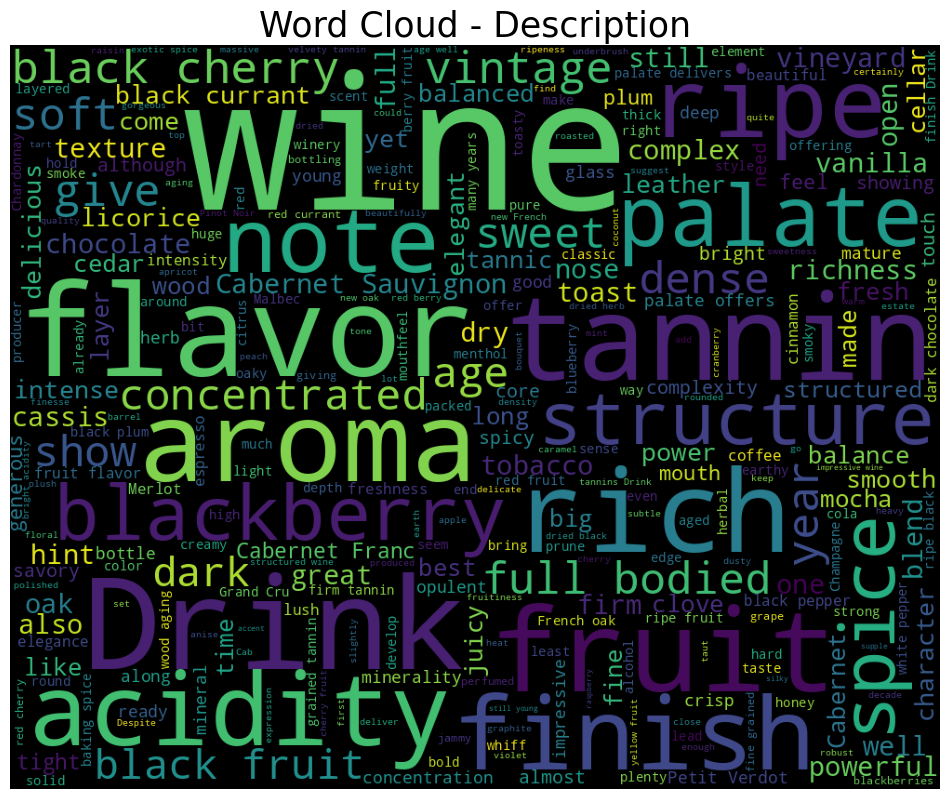

In [177]:
wordcloud = WordCloud(
    stopwords=stopwords.words('english'),
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df[df["price"]>100]["description"].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("Word Cloud - Description",fontsize=25)
plt.axis('off')

Облака слов достаточно похожи

Векторизуем через TF-IDF и уменьшим размерность, чтобы DBSCAN быстрее обучился

In [174]:
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'), tokenizer = tokenize, max_features = 1000)
X = vectorizer.fit_transform(df["description"].to_list())

words = vectorizer.get_feature_names_out()
svd = TruncatedSVD(n_components=100, random_state=42)
X = svd.fit_transform(X) 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


In [175]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(min_samples=3, eps=0.5)

dbscan_model.fit(X)

df['cluster'] = dbscan_model.labels_

Посчитаем силуэт. Достаточно плохой(

In [180]:
metrics.silhouette_score(X, df['cluster'])

-0.024947618060957008

Посмотрим как кластеры пересекаются с дорогими/дешевыми винами. Как можно, видеть, кластеров получилось много и везде преобладают дешевые вина. В целом это неудивительно, учитывая схожести их облак слов



In [176]:
df.groupby(['cluster'])['cheapesness'].agg(pd.Series.mode)

cluster
-1     cheap
 0     cheap
 1     cheap
 2     cheap
 3     cheap
 4     cheap
 5     cheap
 6     cheap
 7     cheap
 8     cheap
 9     cheap
 10    cheap
 11    cheap
 12    cheap
 13    cheap
 14    cheap
 15    cheap
 16    cheap
 17    cheap
 18    cheap
 19    cheap
 20    cheap
 21    cheap
 22    cheap
 23    cheap
 24    cheap
 25    cheap
 26    cheap
 27    cheap
Name: cheapesness, dtype: object

Куда лучше кластеры оверлэпятся с вином, возможно с самыми популярными сортами (для данных для второго кластеринга мы не брали только топ-20 самых популярных вин)

In [191]:
df.groupby(['cluster'])['variety'].agg(pd.Series.mode)

cluster
-1                                            Chardonnay
 0                                            Pinot Noir
 1                                           White Blend
 2                                                 Gamay
 3                                       Sparkling Blend
 4                              Bordeaux-style Red Blend
 5                              Bordeaux-style Red Blend
 6                              Bordeaux-style Red Blend
 7                                        Portuguese Red
 8                                      Portuguese White
 9                                        Gewürztraminer
 10    [Bordeaux-style Red Blend, Cabernet Franc, Pin...
 11                         [Barbera, Merlot, Red Blend]
 12                                                 Rosé
 13        [Cabernet Sauvignon, Portuguese Red, Verdejo]
 14                                           Chardonnay
 15     [Cabernet Franc, Cabernet Sauvignon, Pinot Noir]
 16                    

Посмотрим на топ 5 вин для 27 кластеров

In [192]:
top_wine = (df.assign(count=df.groupby(["cluster","variety"])["variety"].transform("count"))
        .drop_duplicates(["cluster","variety"])
        .sort_values(["cluster","count"], ascending=False))

In [193]:
print(pd.DataFrame([i["variety"].unique()[:5] for _, i in top_wine.groupby("cluster")]).fillna(np.NaN))

                           0                           1                   2  \
0                 Chardonnay                  Pinot Noir  Cabernet Sauvignon   
1                 Pinot Noir                  Chardonnay  Cabernet Sauvignon   
2                White Blend                 Pinot Blanc                 NaN   
3                      Gamay              Portuguese Red                 NaN   
4            Sparkling Blend    Bordeaux-style Red Blend                 NaN   
5   Bordeaux-style Red Blend                         NaN                 NaN   
6   Bordeaux-style Red Blend                  Chardonnay                 NaN   
7   Bordeaux-style Red Blend                    Castelão                 NaN   
8             Portuguese Red              Grenache-Syrah                 NaN   
9           Portuguese White              Portuguese Red                 NaN   
10            Gewürztraminer  Bordeaux-style White Blend                 NaN   
11  Bordeaux-style Red Blend            

Кажется текст описания куда лучше оверлэпится с сортом вина (чем с ценами)